## Imports
Here we will do our usual imports. I would recommend numpy, scipy, skimage, sklearn, pytorch, and matplotlib. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_Helper module as well.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towards them.

In [2]:
class PacmanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        initialise data set
        :param root_dir: file path which contains 'positives' and 'negatives' 
        :param transform: the transformation operation to be applied to each image
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # load positives
        pos_dir = os.path.join(root_dir, 'positives')
        self.images += [os.path.join(pos_dir, file) for file in os.listdir(pos_dir)]
        self.labels += [1] * len(os.listdir(pos_dir))  # 1 for positives

        # load negatives
        neg_dir = os.path.join(root_dir, 'negatives')
        self.images += [os.path.join(neg_dir, file) for file in os.listdir(neg_dir)]
        self.labels += [0] * len(os.listdir(neg_dir))  # 0 for negatives

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [4]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # random flip
    # specific rotations
    transforms.RandomChoice([
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [5]:
# create data-set
dataset = PacmanDataset(root_dir='training_data/img')

# initialise the size of datasets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# divided into three datasets
train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, stratify=dataset.labels)
train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (val_size + train_size), stratify=[dataset.labels[i] for i in train_val_indices])

train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

train_dataset = PacmanDataset(root_dir='training_data/img', transform=transform_augmented)
train_dataset.images = [train_subset.dataset.images[i] for i in train_indices]
train_dataset.labels = [train_subset.dataset.labels[i] for i in train_indices]

val_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
val_dataset.images = [val_subset.dataset.images[i] for i in val_indices]
val_dataset.labels = [val_subset.dataset.labels[i] for i in val_indices]

test_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
test_dataset.images = [test_subset.dataset.images[i] for i in test_indices]
test_dataset.labels = [test_subset.dataset.labels[i] for i in test_indices]

# create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Check the data leakage

In [6]:
def check_for_leakage(train_data, val_data, test_data):
    # get the full list of image paths for each dataset 
    train_set = set(train_data.images)
    val_set = set(val_data.images)
    test_set = set(test_data.images)

    # check for overlap 
    train_val_overlap = train_set.intersection(val_set)
    train_test_overlap = train_set.intersection(test_set)
    val_test_overlap = val_set.intersection(test_set)

    # print the results
    print(f"Train/Validation overlap: {len(train_val_overlap)} images")
    print(f"Train/Test overlap: {len(train_test_overlap)} images")
    print(f"Validation/Test overlap: {len(val_test_overlap)} images")

    # return True if there's any overlap, indicating leakage
    leakage = len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0
    return leakage

In [7]:
# run the leakage check
leakage_detected = check_for_leakage(train_dataset, val_dataset, test_dataset)
if leakage_detected:
    print("Data leakage detected!")
else:
    print("No data leakage detected.")

Train/Validation overlap: 0 images
Train/Test overlap: 0 images
Validation/Test overlap: 0 images
No data leakage detected.


### Showing examples in data loader

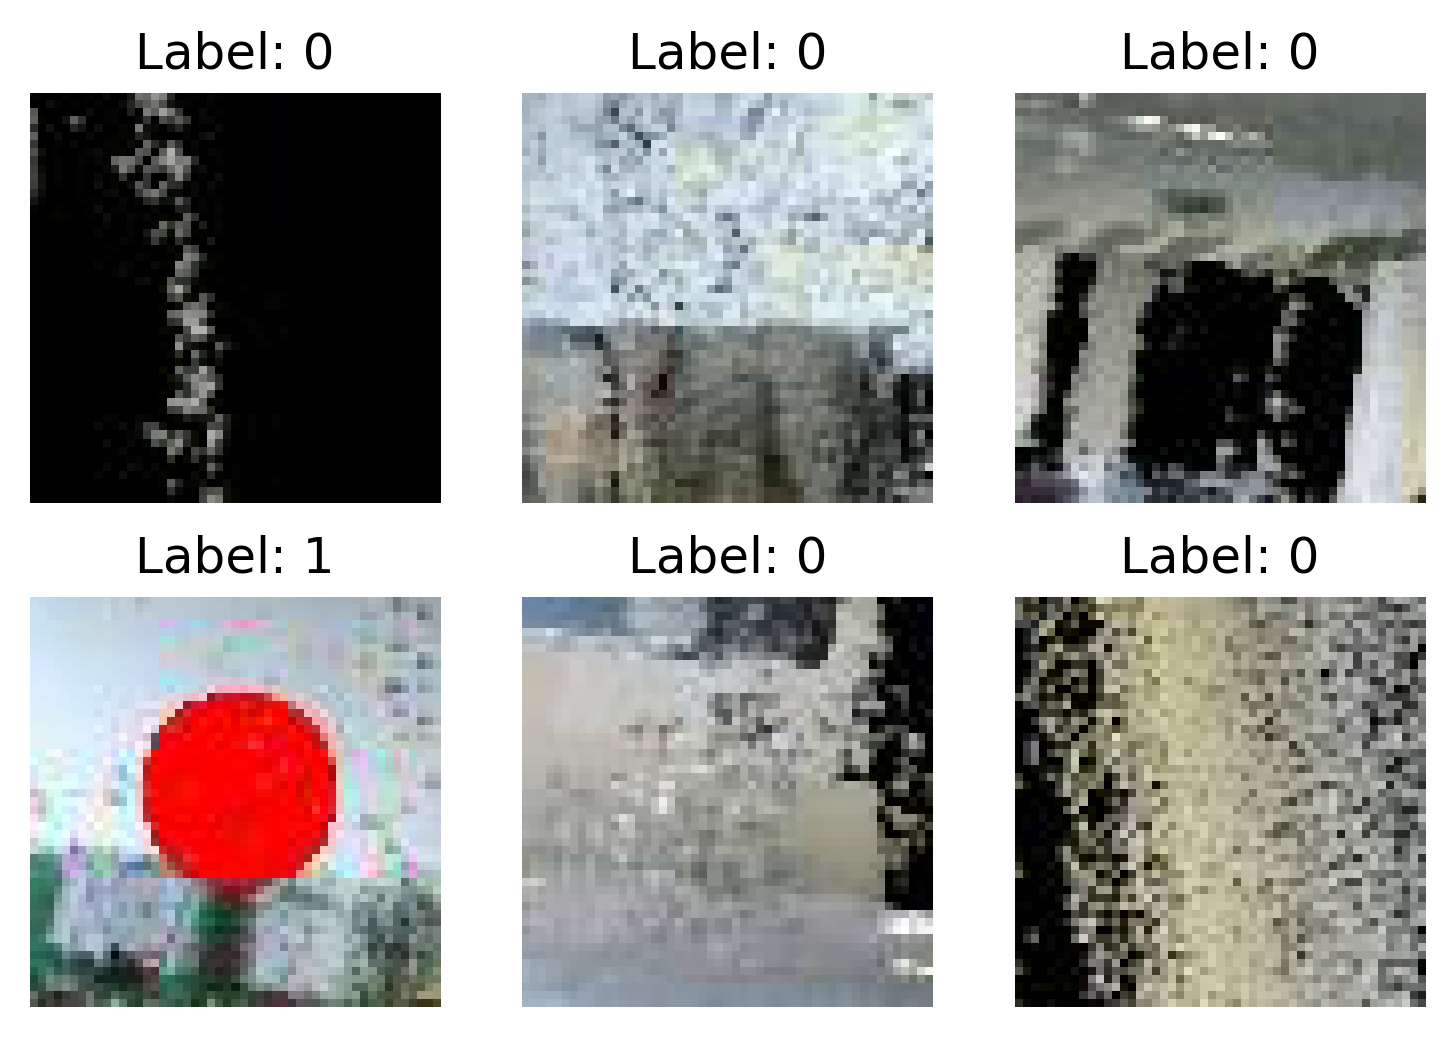

In [22]:
# get a batch size of data from data loader
images, labels = next(iter(train_loader))

# plot 6 examples in data loader
fig, axs = plt.subplots(2, 3, figsize=(6, 4), dpi = 300)

for i, ax in enumerate(axs.flat):
    # convert tensor to numpy
    img = images[i].numpy().transpose((1, 2, 0))
    
    # denormalise images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # plot
    ax.imshow(img)
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

## Define the CNN Model

### Check GPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f'Using GPU: {gpu_name}')
else:
    print('CUDA is not available, using CPU.')

Using GPU: NVIDIA GeForce RTX 3070


### Create CNN Architecture

In [10]:
class SimpleCNN(nn.Module):
    """
    A simple convolutional neural network model for binary classification of images.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(-1, 128 * 6 * 6)
        
        # dropout layer
        x = self.dropout(x)
        
        # 1st fully connected layer with relu activation function
        x = F.relu(self.fc1(x))
        
        # dropout layer
        x = self.dropout(x)
        
        # 2nd fully connected layer with relu activation function
        x = F.relu(self.fc2(x))
        
        # dropout layer
        x = self.dropout(x)
        
        # 3rd fully connected layer with sigmoid activation function
        # as this is binary classification
        x = torch.sigmoid(self.fc3(x))
        
        return x

### Instantiate the model and send to GPU

In [11]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Define the loss function and optimiser

In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Define the training function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        y_true_train = []
        y_pred_train = []
        
        # iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            # backward + optimise
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_train.extend(labels.tolist())
            y_pred_train.extend(preds.flatten().tolist())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        epoch_precision = precision_score(y_true_train, y_pred_train)
        epoch_recall = recall_score(y_true_train, y_pred_train)
        epoch_f1_score = f1_score(y_true_train, y_pred_train)
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1_score:.4f}')
        
        # copy the model if it has better accuracy on the val-set
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # if the model has not improved for 'patience' times, stop the loop early.
        if epochs_no_improve == patience:
            print('Early stopping initiated')
            break
        
        # validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        y_true_val = []
        y_pred_val = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                preds = torch.round(outputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.unsqueeze(1).data)
                
                y_true_val.extend(labels.tolist())
                y_pred_val.extend(preds.flatten().tolist())
            
            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)
            
            val_precision = precision_score(y_true_val, y_pred_val)
            val_recall = recall_score(y_true_val, y_pred_val)
            val_f1_score = f1_score(y_true_val, y_pred_val)
            
            print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            print(f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1_score:.4f}')
            print()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train the Network

In [14]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5)

Epoch 0/24
----------
Train Loss: 0.1003 Acc: 0.9572
Precision: 0.9161, Recall: 0.6574, F1-score: 0.7655
Validation Loss: 0.0151 Acc: 0.9908
Precision: 1.0000, Recall: 0.9130, F1-score: 0.9545

Epoch 1/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0015 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 2/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0007 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 3/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0006 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 4/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0004 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Epoch 5/24
----------
Train Lo

## 7. Save the Model
Save the trained model for future use.

In [15]:
torch.save(model.state_dict(), 'model.pth')

## 8.Test the Model
Evaluate the model's performance on the test dataset.

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_test.extend(labels.tolist())
            y_pred_test.extend(preds.flatten().tolist())
        
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_corrects.double() / len(test_loader.dataset)
        
        test_precision = precision_score(y_true_test, y_pred_test)
        test_recall = recall_score(y_true_test, y_pred_test)
        test_f1_score = f1_score(y_true_test, y_pred_test)
        
        print('Test Results:')
        print('-' * 10)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        print(f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1_score:.4f}')

In [17]:
# criterion for evaluation 
criterion_eval = nn.BCELoss()

# evaluate the model on test set
evaluate_model(model, test_loader, criterion_eval)

Test Results:
----------
Test Loss: 0.0111 Acc: 0.9954
Precision: 1.0000, Recall: 0.9565, F1-score: 0.9778


In [18]:
def visualize_predictions(model, test_loader, num_images=6):
    model.eval()  # set model to evaluation mode
    images_handeled = 0
    plt.figure(figsize=(15, 20), dpi = 300)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            
            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 5, images_handeled)
                ax.axis('off')
                ax.set_title(f'True: {labels[j].item()} - Pred: {preds[j].item()}')
                input_img = inputs.cpu().data[j] # move the image tensor to cpu
                input_img = input_img.numpy().transpose((1, 2, 0)) # recover channels
                # denormalisation
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_img = std * input_img + mean
                input_img = np.clip(input_img, 0, 1)
                plt.imshow(input_img)
                
                if images_handeled == num_images:
                    return
    plt.show()

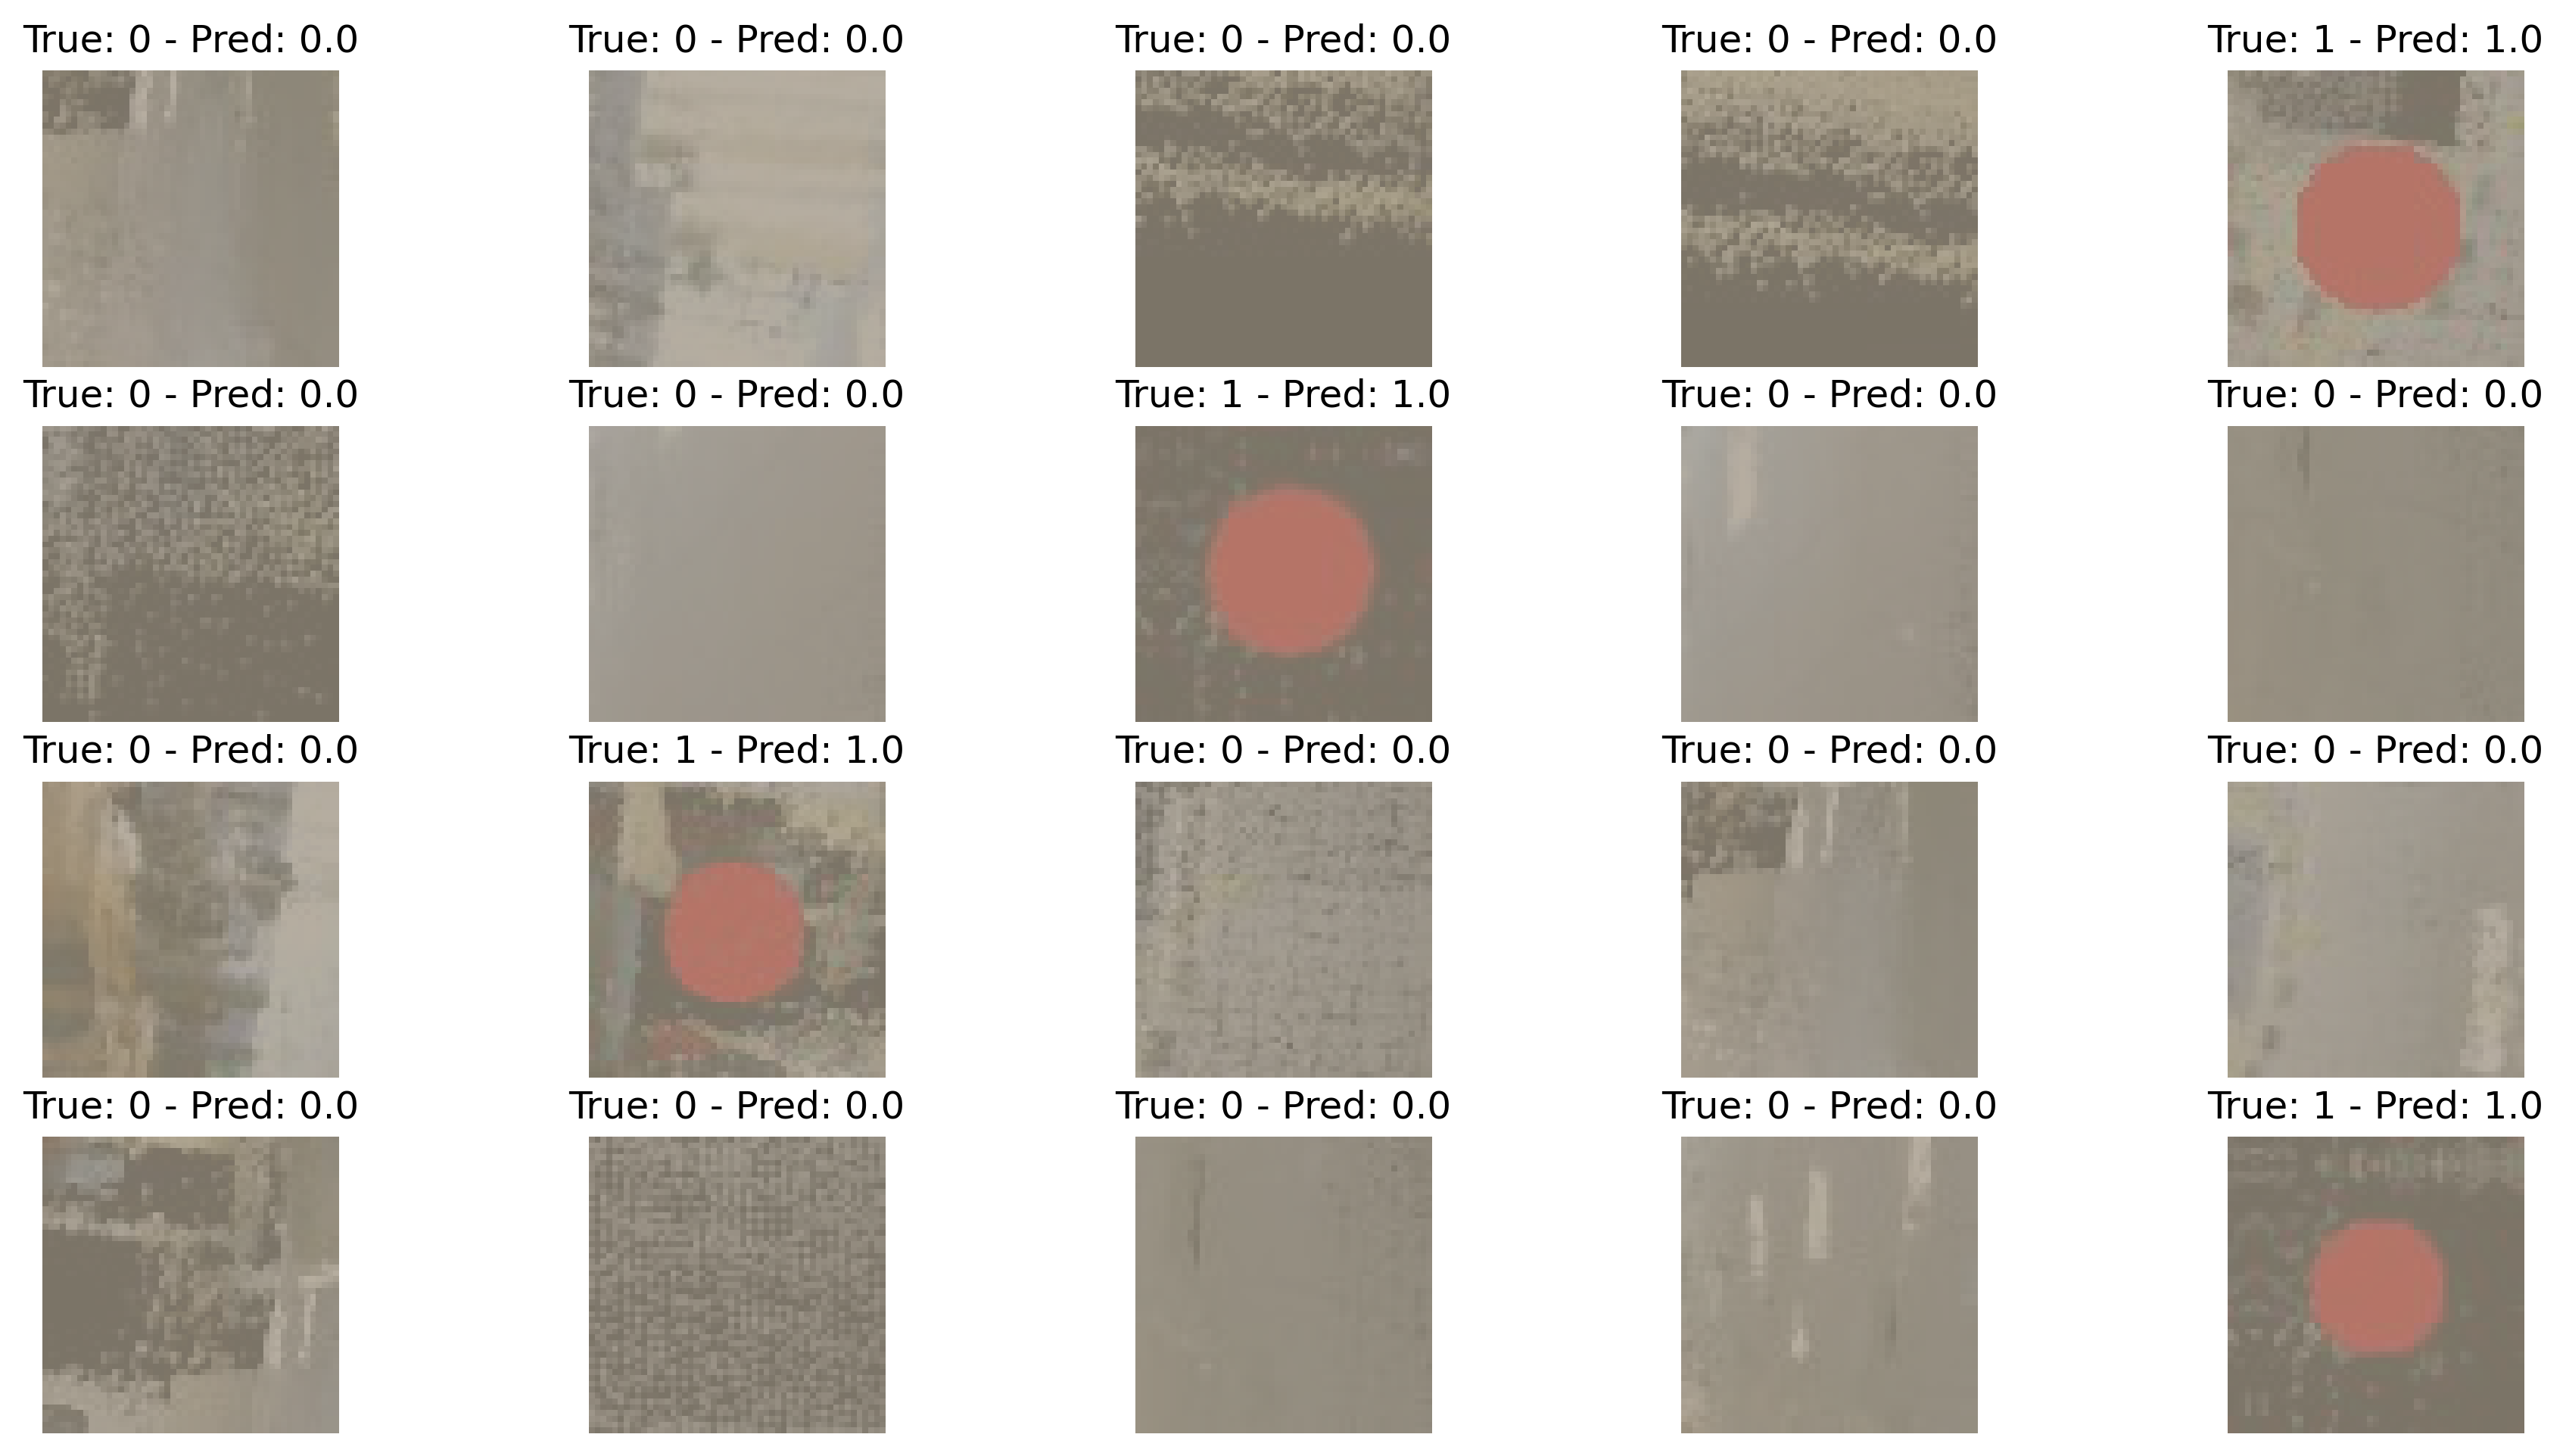

In [19]:
visualize_predictions(model, test_loader, num_images=20)